In [93]:
import src.backtest_utils as sbtu
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import src.utils.regime as sur
import src.utils.pd_accessors as pda
import numpy as np

In [94]:
_data_loader = sbtu.DataLoader.init_from_paths('other.json', 'base.json')
_strategy_path = _data_loader.file_path('strategy_lookup.pkl')
with open(_strategy_path, 'rb') as f:
    _strategy_lookup = pickle.load(f)

_entry_path = _data_loader.file_path('entry_table_15m.pkl')
with open(_entry_path, 'rb') as f:
    _entry_table = pickle.load(f)

_peak_path = _data_loader.file_path('peak_table_15m.pkl')
with open(_peak_path, 'rb') as f:
    _peak_table = pickle.load(f)

_bench_str = 'SPY'
_interval = '15m'
_price_data = pd.read_csv(_data_loader.history_path(_bench_str, _interval), index_col=0, header=[0,1]).astype('float64')
_bench = pd.read_csv(_data_loader.bench_path(_bench_str, _interval), index_col=0).astype('float64')
_relative_rebased = sbtu.PriceGlob(_price_data).relative_rebased(_bench.close)
_strategy_overview = pd.read_csv(_data_loader.file_path('stat_overview_15m.csv'))

_price_data_by_symbol = sbtu.PriceGlob(_price_data).swap_level()

<AxesSubplot:title={'center':'MET'}>

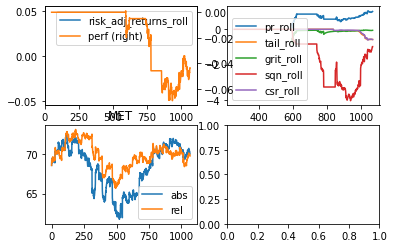

In [95]:
symbol = 'MET'
_strat_data = _strategy_lookup[symbol]
_stats = _strategy_lookup[symbol].stat_historical
fig, axs = plt.subplots(2, 2)
_stats[['risk_adj_returns_roll', 'perf']].plot(secondary_y=['perf'], ax=axs[0, 0])
plot_copy = _stats[['pr_roll', 'tail_roll', 'grit_roll', 'sqn_roll', 'csr_roll']]
plot_copy.plot(ax=axs[0, 1])

def get_abs_rel(_s):
    sd = _price_data_by_symbol.data[_s]
    rel = sur.simple_relative(sd, _bench.close).close
    return pd.DataFrame(
        data={
            'abs': sd.close,
            'rel': rel
        }
    )

_symbol_data = _price_data_by_symbol.data[symbol]
get_abs_rel(symbol).plot(title=symbol, ax=axs[1, 0])

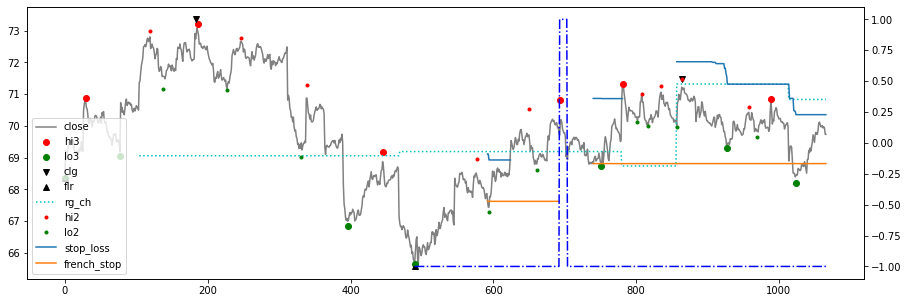

In [96]:
import src.scanner as scanner

epd = _strategy_lookup[symbol].enhanced_price_data.copy()
epd['french_stop'] = _strategy_lookup[symbol].french_stop.stop_price
_sl = _strategy_lookup[symbol].stop_loss_series
_sl = _sl.loc[~_sl.index.duplicated(keep='first')]
epd['stop_loss'] = _sl
# epd['base_close'] = _symbol_data.close
scanner.enhanced_price_data_plot(epd)

In [97]:

_pt = _strategy_lookup[symbol].peak_table.copy()

_pt['px'] = np.where(
    _pt.type == 1,
    epd.low.loc[_pt.start],
    epd.high.loc[_pt.start],
)
_pt = pda.PeakTable(_pt)
_pt = _pt.unpivot(_symbol_data.index)
_pt = _pt.loc[~_pt.index.duplicated(keep='first')]
_shi_px = _pt.loc[(_pt.type == -1)]
_shi_1 = _shi_px.loc[(_shi_px.lvl == 1), 'px']
_shi_2 = _shi_px.loc[(_shi_px.lvl == 2), 'px']
_shi_3 = _shi_px.loc[(_shi_px.lvl == 3), 'px']

_slo_px = _pt.loc[(_pt.type == 1)]
_slo_1 = _slo_px.loc[(_slo_px.lvl == 1), 'px']
_slo_2 = _slo_px.loc[(_slo_px.lvl == 2), 'px']
_slo_3 = _slo_px.loc[(_slo_px.lvl == 3), 'px']

<AxesSubplot:>

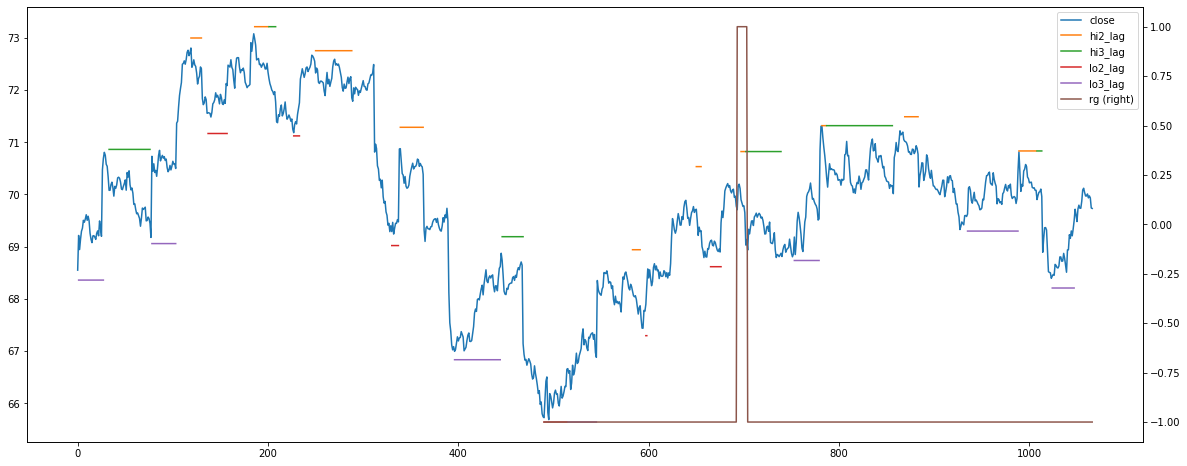

In [98]:
epd['hi1_lag'] = _shi_1
epd['hi2_lag'] = _shi_2
epd['hi3_lag'] = _shi_3
epd['lo1_lag'] = _slo_1
epd['lo2_lag'] = _slo_2
epd['lo3_lag'] = _slo_3

epd[
    ['close', 'hi2_lag', 'hi3_lag', 'lo2_lag', 'lo3_lag', 'rg']
].plot(figsize=(20, 8), secondary_y='rg')

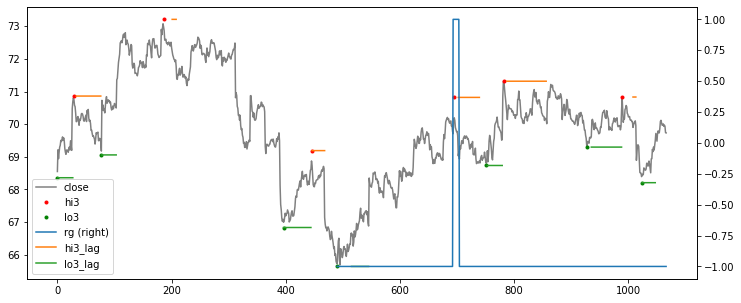

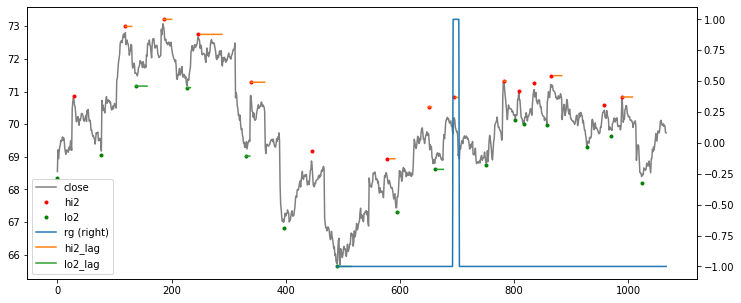

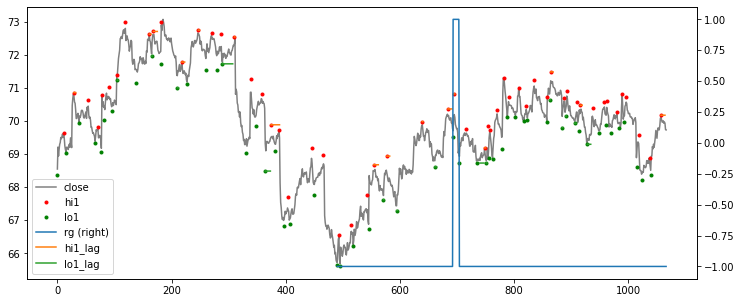

In [99]:
import src.utils.regime as regime
import matplotlib.pyplot as plt

_epd_plt = epd[['close', 'hi2', 'lo2', 'hi3', 'lo3', 'rg']]

def plot(lvl):
    epd[['close', f'hi{lvl}', f'lo{lvl}', 'rg', f'hi{lvl}_lag', f'lo{lvl}_lag']].plot(style=['grey', 'r.', 'g.'], figsize=[12, 5], secondary_y='rg')

plot(3)
plot(2)
plot(1)

<AxesSubplot:title={'center':'lvl3 lag'}, ylabel='Frequency'>

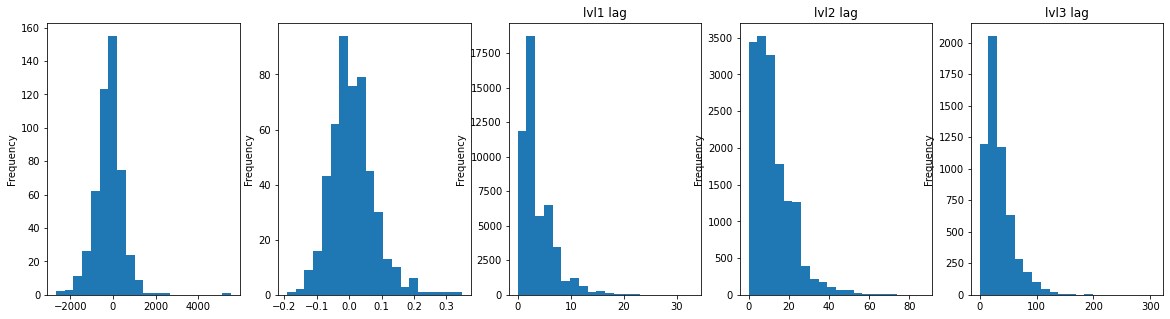

In [100]:
fig, axs = plt.subplots(1, 5)
_strategy_overview.weight_total.plot.hist(bins=20, ax=axs[0], figsize=(20, 5))
_strategy_overview.perf.plot.hist(bins=20, ax=axs[1])

_peak_table['peak_lag'] = _peak_table.end - _peak_table.start
partial_exit_lag = _entry_table.partial_exit_date - _entry_table.entry
_peak_table.loc[_peak_table.lvl == 1, 'peak_lag'].plot.hist(bins=20, ax=axs[2], title='lvl1 lag')
_peak_table.loc[_peak_table.lvl == 2, 'peak_lag'].plot.hist(bins=20, ax=axs[3], title='lvl2 lag')
_peak_table.loc[_peak_table.lvl == 3, 'peak_lag'].plot.hist(bins=20, ax=axs[4], title='lvl3 lag')

In [101]:
_peak_table.loc[(_peak_table.lvl == 3) & (_peak_table.peak_lag > 200)]

,start,end,type,lvl,st_px,en_px,symbol,peak_lag
1,1,238,1,3,161.470180,164.806190,DOV,237
8,55,362,-1,3,69.071652,67.278015,JCI,307
107,799,1007,-1,3,118.554465,115.155023,LYV,208


<AxesSubplot:title={'center':'Entry/Partial Exit Delay'}, ylabel='Frequency'>

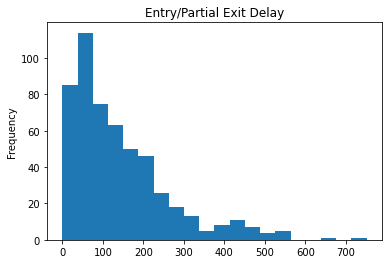

In [102]:
(_entry_table.partial_exit_date - _entry_table.entry).plot.hist(bins=20, title='Entry/Partial Exit Delay')

<AxesSubplot:ylabel='Frequency'>

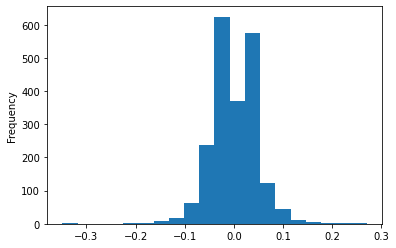

In [103]:
_entry_table['r'] = (_entry_table.fixed_stop_price - _entry_table.en_px) / _entry_table.en_px
_entry_table['r'].plot.hist(bins=20)

In [104]:
_entry_table.loc[abs(_entry_table.r) > 0.2]

,trail_stop,entry,st_px,en_px,dir,fixed_stop,exit_signal_date,partial_exit_date,fixed_stop_price,rg_id,...,partial_exit,risk,shares,partial_profit,rem_profit,partial_total,no_partial_total,my_total,total,r
0,474.0,494.0,160.473112,168.637044,1.0,312.0,632.0,NaN,133.276712,1.0,...,194.865005,-0.0075,11.0,19.956675,-1.256663,18.700012,-41.469879,18.700012,18.700012,-0.209683
0,561.0,577.0,210.815747,203.574629,-1.0,430.0,613.0,NaN,258.575112,0.0,...,324.549988,-0.0075,-8.0,90.726654,4.016663,94.743317,-96.399902,94.743317,94.743317,0.270174
1,705.0,729.0,275.188956,281.709661,1.0,524.0,757.0,NaN,183.404298,1.0,...,NaN,-0.0075,4.0,NaN,-1.198334,NaN,-14.380005,-14.380005,80.363312,-0.348960
0,551.0,568.0,58.084556,56.720220,-1.0,363.0,870.0,NaN,70.342067,0.0,...,NaN,-0.0075,-33.0,NaN,0.900000,NaN,-89.100025,-89.100025,-89.100025,0.240159
1,1041.0,1049.0,26.927570,27.099723,1.0,891.0,1066.0,NaN,21.540227,3.0,...,NaN,-0.0075,80.0,NaN,-0.008333,NaN,-1.999969,-1.999969,-84.679941,-0.205150
3,881.0,884.0,997.533808,1046.179622,1.0,651.0,1066.0,NaN,812.330639,1.0,...,NaN,-0.0075,1.0,NaN,5.574992,NaN,16.724976,16.724976,-242.436198,-0.223527
0,365.0,366.0,12.768790,12.509929,-1.0,355.0,675.0,NaN,15.204345,0.0,...,NaN,-0.0075,-135.0,NaN,-0.483333,NaN,195.749974,195.749974,195.749974,0.215382


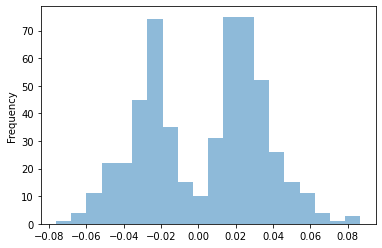

In [105]:
ax = _entry_table.loc[_entry_table.partial_exit_date.notna() ,'r'].plot.hist(bins=20, alpha=0.5, label='y')
# ax = _entry_table.loc[_entry_table.partial_exit_date.isnull() ,'r'].plot.hist(bins=20, alpha=0.5, label='x', ax=ax

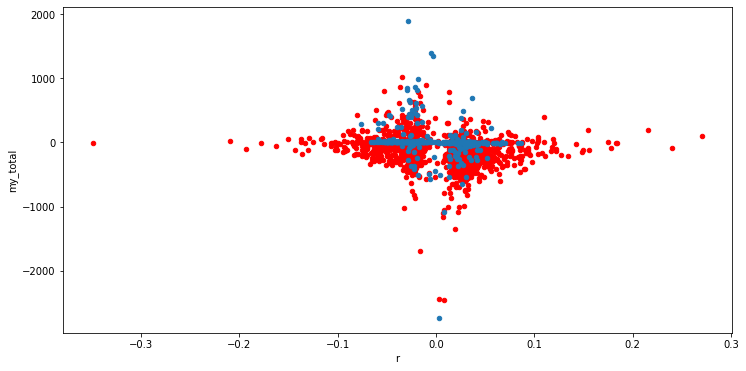

In [106]:
ax = _entry_table.loc[
    (_entry_table.exit_signal_date != _symbol_data.index[-1]) &
    (_entry_table.partial_exit_date.isna())
].plot.scatter(x='r', y='my_total', figsize=[12, 6], color='r')
_entry_table.loc[
    (_entry_table.exit_signal_date != _symbol_data.index[-1]) &
    (_entry_table.partial_exit_date.notna())
].plot.scatter(x='r', y='my_total', ax=ax)
_cpy = _entry_table[['r', 'my_total']].sort_values(by='r').reset_index(drop=True)
_cpy['w'] = _cpy.loc[_cpy.my_total > 0, 'my_total']
_cpy['l'] = _cpy.loc[_cpy.my_total < 0, 'my_total']
# _cpy.hist(by='r', bins=20)

<AxesSubplot:xlabel='sig_len', ylabel='my_total'>

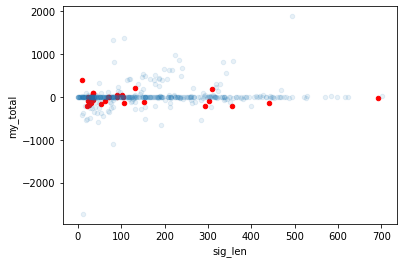

In [107]:
_prev_exits = _entry_table.loc[
    (_entry_table.exit_signal_date != _symbol_data.index[-1])
].copy()
_prev_exits['sig_len'] = (_prev_exits.exit_signal_date - _prev_exits.entry)
_prev_exits['partial_sig_len'] = (_prev_exits.partial_exit_date - _prev_exits.entry)
ax = _prev_exits.loc[(_prev_exits.r > 0.1)].plot.scatter(x='sig_len', y='my_total', color='r')
_prev_exits.loc[_prev_exits.partial_exit_date.notna()].plot.scatter(x='sig_len', y='my_total', ax=ax, alpha=0.1)

<AxesSubplot:xlabel='r', ylabel='sig_len'>

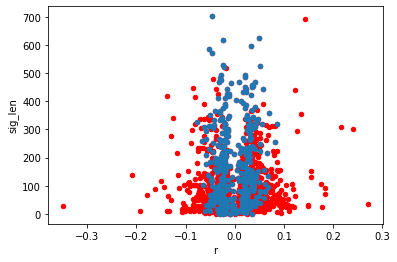

In [108]:
ax = _prev_exits.plot.scatter(x='r', y='sig_len', color='r')
_prev_exits.loc[_prev_exits.partial_exit_date.notna()].plot.scatter(x='r', y='sig_len', ax=ax)

In [109]:
# _relative_rebased.plot(figsize=(20, 8))
x = _relative_rebased.iloc[-1]
x = x.loc[x < 1].sort_values()


<AxesSubplot:xlabel='partial_sig_len', ylabel='partial_total'>

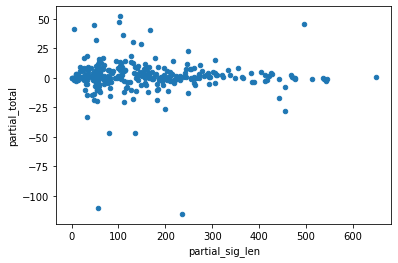

In [110]:
# get_abs_rel('AAPL').plot(
# _prev_exits.loc[_prev_exits.sig_len > 500]
_prev_exits.plot.scatter(x='partial_sig_len', y='partial_total')